#  <center> Speech Stress Recognition <center>

## Import Code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!sudo apt-get update
!sudo apt-get install -y libsndfile1 -y
!pip install --upgrade pip
!sudo apt-get install portaudio19-dev -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [46.6 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,419 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [49.8 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadc

In [2]:
!pip install librosa keras tensorflow SpeechRecognition pyaudio ipywebrtc soundfile
!pip install --upgrade librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 17.4 MB/s eta 0:00:00
  Created wheel for pyaudio: filename=PyAudio-0.2.13-cp310-cp310-linux_x86_64.whl size=63863 sha256=b14cdb0feb473d2537b54ff9b7956a6774f24b298507c5d6d8f6d36618697de6
  Stored in directory: /root/.cache/pip/wheels/14/f1/c2/d102b4765a82c5a7bb273998dca7e4a53fc58e9a1a516fda81
Successfully built pyaudio


In [3]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import speech_recognition as sr

import soundfile as sf

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Path Import

In [15]:
# Paths for data.
AudioSPH = "/home/jupyter/imported/skripsi/kaggler/input/AudioSPH/"
AudioWAV = "/content/Dataset_SUSASS/"
SAVE_MODEL = "/content/drive/MyDrive/Colab Notebooks/Skripsi-ML/model_1.h5"

##### Dataframe

In [16]:
audio_directory_list = os.listdir(AudioWAV)

file_emotion = []
file_path = []
for file in audio_directory_list:
    part = file.split('.')[0]
    part = part.split('-')
    # third part in each file represents the emotion associated to that file.
    file_emotion.append(part[0])
    file_path.append(AudioWAV + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Audio_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Audio_df.Emotions.replace({1:'LowStress', 2:'HighStress'}, inplace=True)
Audio_df.head()

,Emotions,Path
0,LowStress,/content/Dataset_SUSASS/LowStress-m1-change2.wav
1,LowStress,/content/Dataset_SUSASS/LowStress-m1-three1.wav
2,LowStress,/content/Dataset_SUSASS/LowStress-m1-wide1.wav
3,HighStress,/content/Dataset_SUSASS/HighStress-m4-wide2.wav
4,LowStress,/content/Dataset_SUSASS/LowStress-m4-enter3.wav


In [17]:
data_path = Audio_df
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,LowStress,/content/Dataset_SUSASS/LowStress-m1-change2.wav
1,LowStress,/content/Dataset_SUSASS/LowStress-m1-three1.wav
2,LowStress,/content/Dataset_SUSASS/LowStress-m1-wide1.wav
3,HighStress,/content/Dataset_SUSASS/HighStress-m4-wide2.wav
4,LowStress,/content/Dataset_SUSASS/LowStress-m4-enter3.wav


## Data Visualisation and Exploration

In [18]:
data_path
df = pd.read_csv('data_path.csv')

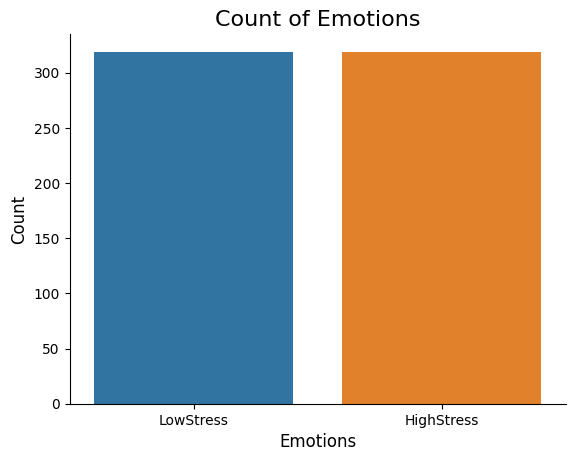

In [19]:
plt.figure(1)
plt.title('Count of Emotions', size=16)
sns.countplot(data=df, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [10]:
pip install --upgrade librosa

In [20]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

/content/Dataset_SUSASS/LowStress-m1-three1.wav PATH


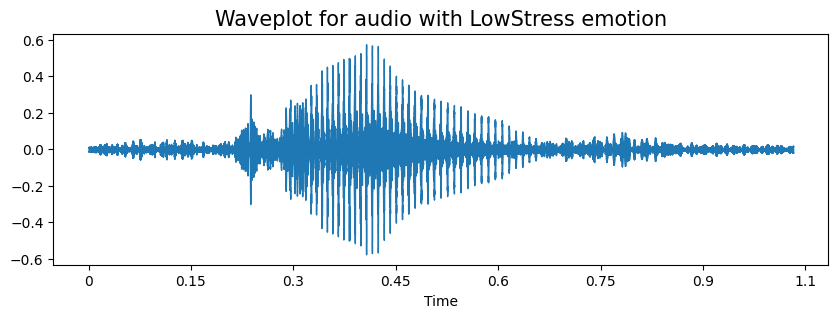

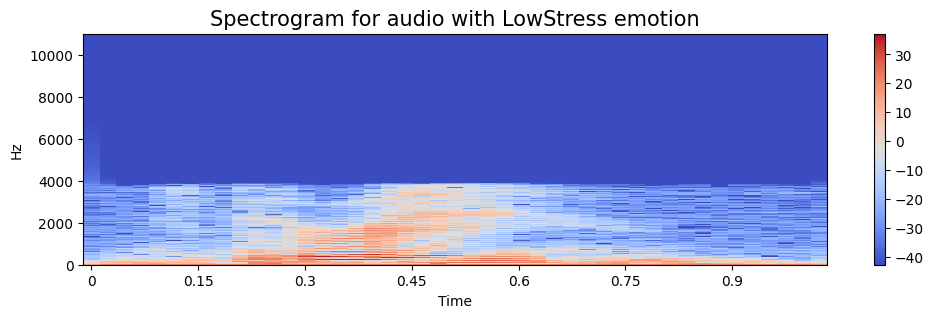

In [21]:
emotion='LowStress'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
print(path, "PATH")
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

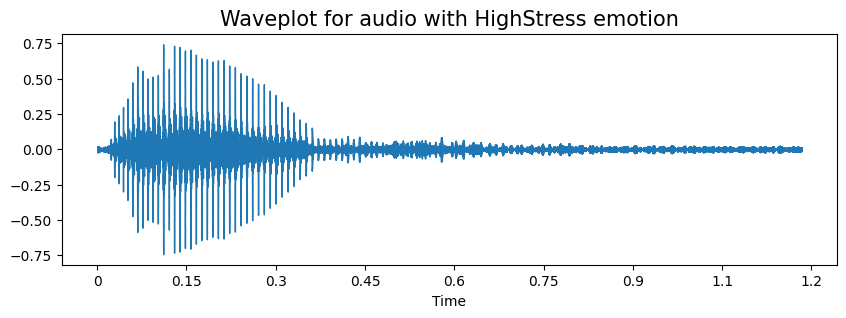

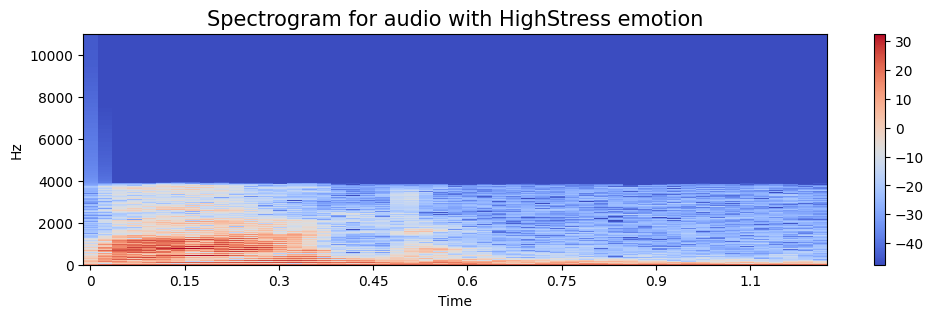

In [22]:
emotion='HighStress'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [23]:
def noise(data):
    if data.size == 0:
        # Handle the case when data is empty
        return data

    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

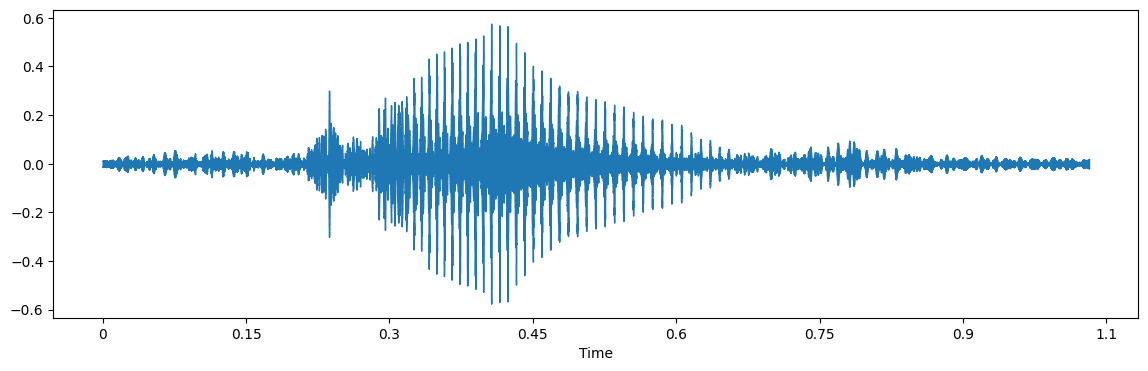

In [24]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

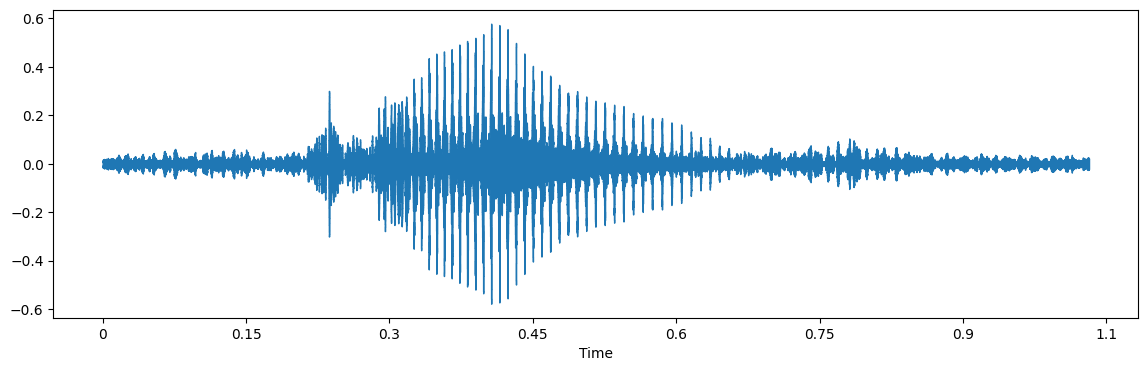

In [25]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Strecthing

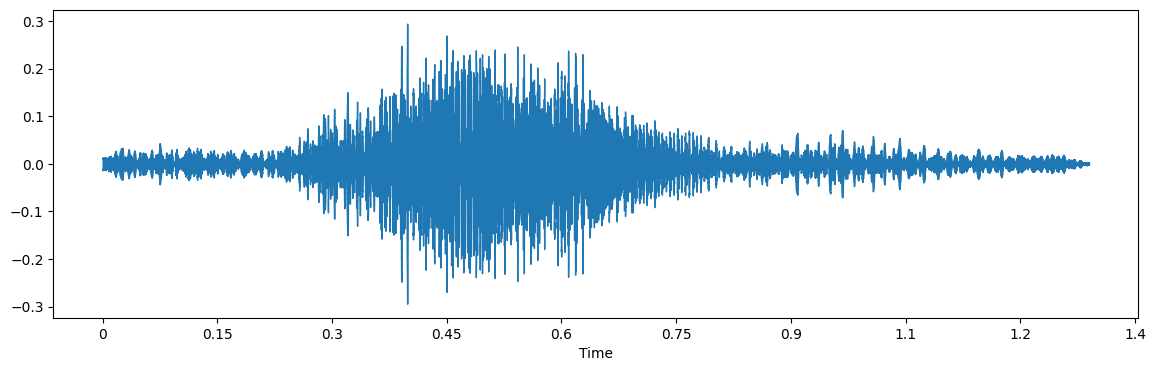

In [26]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

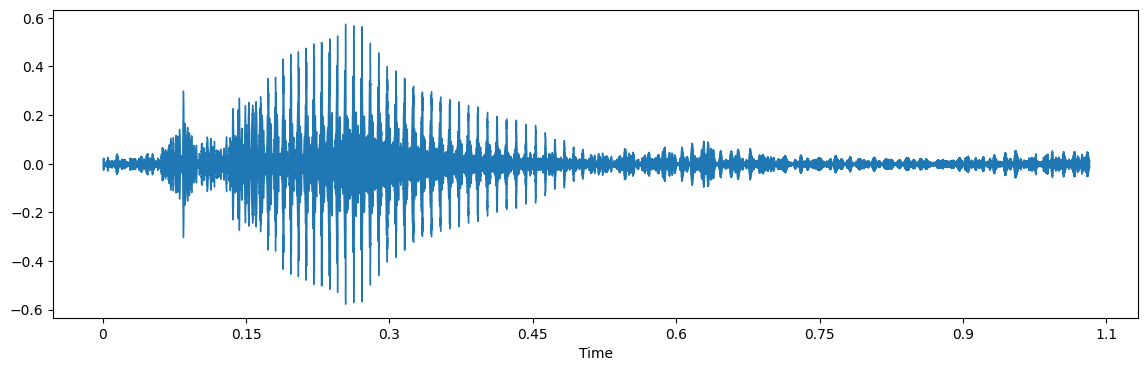

In [27]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitching

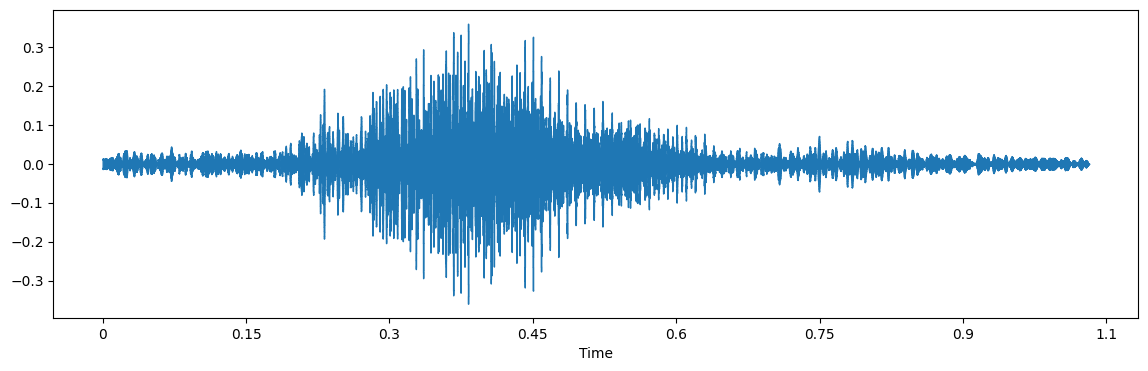

In [28]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction
Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

In [29]:
rms =librosa.feature.rms(y=data).T
rms.shape


(45, 1)

In [ ]:
def rmse(data):
    hop_length = 512
    frame_length = 1024
    n_fft = 1

    rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length, center=True)

    rmse = rmse[0]

    energy = np.array([ sum(abs(x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)])


In [30]:

def mler(rms):
    lef=0
    delta=0.06
    lowthresh=rms.mean()*delta
    for val in rms:
        lef+=np.sign(lowthresh-val)+1
    mler=lef/len(rms)
    return mler

def extract_features(data):
    # ZCR
    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    #spectral contrast
    S = np.abs(librosa.stft(data))
    contrast = np.mean(librosa.feature.spectral_contrast(S=S, sr=sample_rate).T, axis=0)
    result = np.hstack((result, contrast)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(data)
    result = np.vstack((result, res2))

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)

    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):

    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

print('selesai')

In [32]:
len(X), len(Y), data_path.Path.shape
print('tt')

tt


In [33]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,labels
0,-381.074829,189.422653,-41.279564,47.266811,48.223961,-25.876923,17.885067,17.121555,-15.157879,13.590474,...,8.123584,-3.288532,17.398632,12.617910,14.667105,12.950295,15.444333,63.688824,9.428769,LowStress
1,-381.074829,189.422653,-41.279564,47.266811,48.223961,-25.876923,17.885067,17.121555,-15.157879,13.590474,...,8.123584,-3.288532,17.398632,12.617910,14.667105,12.950295,15.444333,63.688824,9.428769,LowStress
2,-439.215942,179.827072,-40.155125,55.711288,42.339119,-27.940392,21.367081,11.387356,-13.206862,16.851549,...,8.899026,-4.633487,20.732062,14.685737,16.905377,15.664342,17.365596,65.531545,14.326653,LowStress
3,-448.437134,216.960449,-29.947208,53.503071,53.024494,-19.356628,18.175892,17.002569,-5.511734,22.239365,...,9.053979,-5.472538,15.591109,12.727406,12.752881,14.148940,15.207349,57.625454,9.101564,LowStress
4,-448.437134,216.960449,-29.947208,53.503071,53.024494,-19.356628,18.175892,17.002569,-5.511734,22.239365,...,9.053979,-5.472538,15.591109,12.727406,12.752881,14.148940,15.207349,57.625454,9.101564,LowStress


## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [34]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [35]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [36]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1435, 27), (1435, 2), (479, 27), (479, 2))

In [37]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1435, 27), (1435, 2), (479, 27), (479, 2))

In [38]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1435, 27, 1), (1435, 2), (479, 27, 1), (479, 2))

## Modelling

#### Model 1 : 1D CNN(256,3 layer) dan save .h5

In [ ]:
model1= Sequential()
model1.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model1.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model1.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model1.add(Dropout(0.2))

model1.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model1.add(Flatten())
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(units=32, activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(units=2, activation='softmax'))
model1.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model1.summary()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)
history=model1.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

model1.save(SAVE_MODEL)

#### Model 2 : 1D CNN(32,3 layer)

In [ ]:
model2 = Sequential()
model2.add(Conv1D(32, 3, activation="relu", padding="same", input_shape=( x_train.shape[1],1)))
model2.add(MaxPooling1D(2))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(128, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(2, activation="softmax"))

# Compile the model
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model2.fit(x_train, y_train, epochs=100,validation_data=(x_test, y_test))

#### Model 3 Coba

In [ ]:
model3=Sequential()
model3.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model3.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model3.add(Dropout(0.2))

model3.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model3.add(Flatten())
model3.add(Dense(units=32, activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(units=2, activation='softmax'))
model3.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 27, 256)           1536      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 14, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 14, 128)           163968    
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 7, 128)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 7, 64)            

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)
history3=model3.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

## Visualize Model

15/15 [==============================] - 0s 10ms/step - loss: 0.6314 - accuracy: 0.8559
Accuracy of our model on test data :  85.5949878692627 %


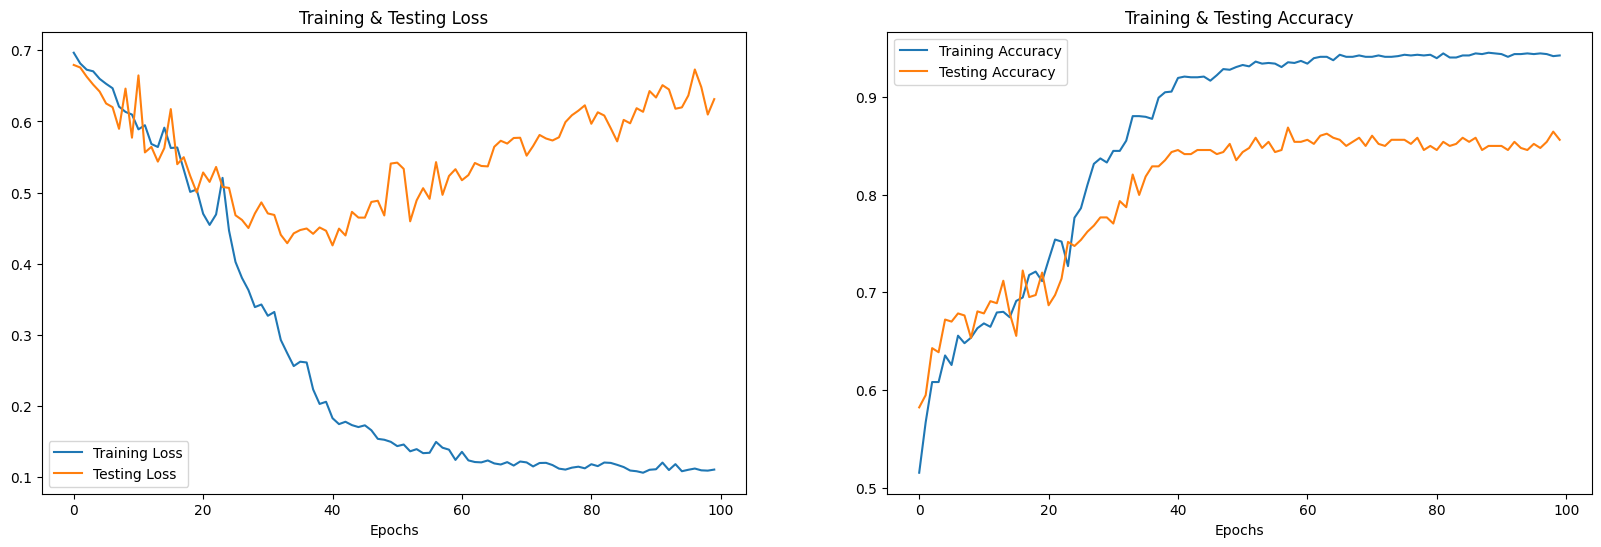

In [41]:
print("Accuracy of our model on test data : " , model1.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

## Preprocess WAV and Predict

In [42]:
def preprocess_wav_file(file_path):
    # Load the WAV file and extract features (you may need to customize this part)
    y, sr = librosa.load(file_path, sr=None)  # Load the WAV file

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Replace with your feature extraction

    return mfccs


#### Uji Predict

1/1 [==============================] - 0s 51ms/step


,Predicted Labels
0,HighStress
1,HighStress
2,HighStress


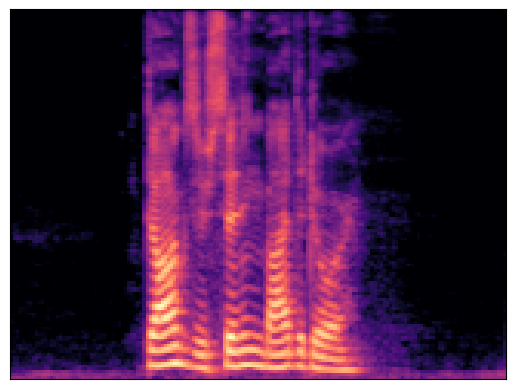

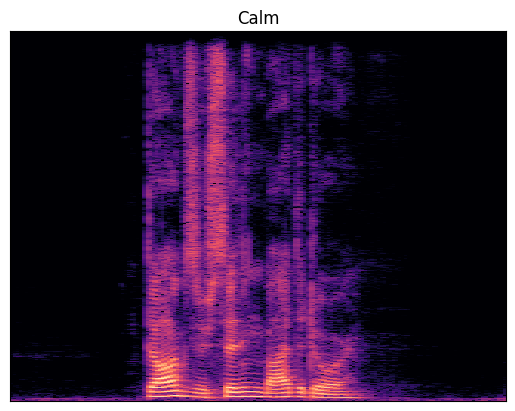

In [94]:
new_wav_file_path = '/content/Data Uji/output_ravdess_kalem.wav'

y, sr = librosa.load(new_wav_file_path)
ms = librosa.feature.melspectrogram(y=y, sr=sr)
log_ms = librosa.power_to_db(ms, ref=np.max)
librosa.display.specshow(log_ms, sr=sr)



S = np.abs(librosa.stft(y))
contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
log_ms = librosa.amplitude_to_db(S,ref=np.max)

fig, ax = plt.subplots(nrows=1, sharex=True)
img1 = librosa.display.specshow(log_ms, sr=sr)

ax.set(title='Calm')

new_data = get_features(new_wav_file_path)
# print (new_data.shape)

new_data = new_data.reshape(new_data.shape[0], new_data.shape[1], 1)

# print (new_data.shape)
pred_test = model1.predict(new_data)  #use various model1, model2 etc. to predict

# Assuming you have class_labels defined already
class_labels = ["HighStress", "LowStress"]

# Fit the encoder on your class labels
encoder = LabelEncoder()
encoder.fit(class_labels)

# you can use the fitted encoder to transform your predictions
y_pred = encoder.inverse_transform(np.argmax(pred_test, axis=1))

df = pd.DataFrame(columns=['Predicted Labels'])
df['Predicted Labels'] = y_pred.flatten()

df.head(10)